In [434]:
import networkx as nx
import numpy as np
pr39 = "METQRASLCLGRWSLWLLLLGLVVPSASAQALSYREAVLRAVDRLNEQSSEANLYRLLELDQPPKADEDPGTPKPVSFTVKETVCPRPTRQPPELCDFKENGRVKQCVGTVTLNPSIHSLDISCNEIQSVRRRPRPPYLPRPRPPPFFPPRLPPRIPPGFPPRFPPRFPGKR"
from disassembly.simulate_proteolysis import simulate_proteolysis, enzyme_set, enzyme
import matplotlib.pyplot as plt

enzymes = enzyme_set(
    [
        enzyme({"K": 1}, "protease_iv"),
        enzyme({"K": 0.5, "R": 0.5}, "trypsin"),
        enzyme({"V": 0.5, "I": 0.25, "A": 0.15, "T": 0.1}, "elne"),
    ],
    [1, 0, 0],  # activities
    [1, 0, 0],  # abundances
)


P, sequence_graph = simulate_proteolysis(
    pr39,
    n_start=5,
    n_generate=50,
    endo_or_exo_probability=[0.1, 0.9],
    enzymes=enzymes,
)
keys = list(P.keys())
values = list(P.values())

P = {k : v /sum(values) for k,v in P.items()}

G = nx.DiGraph()
G.add_nodes_from([(k, {"layer": len(k)}) for k in keys])
for key1 in keys:
    for key2 in keys:
        if (key1 in key2) and (key1 != key2):  # key 1 = ABC, key 2 = ABCD
            G.add_edge(key2, key1, weight=np.random.uniform(0, 1))

for node in G.nodes():
    out_edges = G.out_edges(node, data=True)
    total_out = sum([data["weight"] for _,_,data in G.out_edges(node, data=True)])
    for key, target, data in out_edges:
        nx.set_edge_attributes(
            G, {(key, target): {"weight": .8*data["weight"] / total_out}}
        )

G.out_edges(data=True)

 49 / 50
29 unique peptides. 55 total


OutEdgeDataView([('METQRASLCLGRWSLWLLLLGLVVPSASAQALSYREAVLRAVDRLNEQSSEANLYRLLELDQPPKADEDPGTPKPVSFTVKETVCPRPTRQPPELCDFKENGRVKQCVGTVTLNPSIHSLDISCNEIQSVRRRPRPPYLPRPRPPPFFPPRLPPRIPPGFPPRFPPRFPGKR', 'KADEDPGTPKPVSFTVKETVCPRPTRQPPELCDFKENGRV', {'weight': 0.011476879454113829}), ('METQRASLCLGRWSLWLLLLGLVVPSASAQALSYREAVLRAVDRLNEQSSEANLYRLLELDQPPKADEDPGTPKPVSFTVKETVCPRPTRQPPELCDFKENGRVKQCVGTVTLNPSIHSLDISCNEIQSVRRRPRPPYLPRPRPPPFFPPRLPPRIPPGFPPRFPPRFPGKR', 'KADEDPGTPKPVSFTVKETVCPRPTRQPPELCDFKENGR', {'weight': 0.020419737950680705}), ('METQRASLCLGRWSLWLLLLGLVVPSASAQALSYREAVLRAVDRLNEQSSEANLYRLLELDQPPKADEDPGTPKPVSFTVKETVCPRPTRQPPELCDFKENGRVKQCVGTVTLNPSIHSLDISCNEIQSVRRRPRPPYLPRPRPPPFFPPRLPPRIPPGFPPRFPPRFPGKR', 'ADEDPGTPKPVSFTVKETVCPRPTRQPPELCDFKENGRV', {'weight': 0.05102145924853458}), ('METQRASLCLGRWSLWLLLLGLVVPSASAQALSYREAVLRAVDRLNEQSSEANLYRLLELDQPPKADEDPGTPKPVSFTVKETVCPRPTRQPPELCDFKENGRVKQCVGTVTLNPSIHSLDISCNEIQSVRRRPRPPYLPRPRPPPFFPPRLPPRIPPGFPPRFPPRFPGKR', 'ADEDPGTPKPVSFTVKETVCPRPTRQPPELCDFKENGR',

In [435]:
def generate_guess(G: nx.DiGraph, keys):
    """
    Outputs a tuple of the distribution for the longest node and a matrix
    """
    longest_key = sorted(keys, key=len)[-1]
    p_generated = {}
    terminal_nodes = [node for node in G.nodes() if G.out_degree(node) == 0]
    
    for node in terminal_nodes:  # one hot terminal nodes
        oh_node = create_one_hot(keys, node)
        p_generated[node] = oh_node

    out_edges = {
        source: [target for _, target in G.out_edges(source) if source != target]
        for source in G.nodes()
    }
    

    while len(p_generated.keys()) < len(keys):
        solvables = get_solvable(out_edges, p_generated)
        for solvable in solvables:
            p_generated[solvable] = np.zeros(len(keys))
            
            for source, target in G.out_edges(solvable):
                p_target = p_generated[target]
                w_source_target = G[source][target]["weight"]
                p_generated[source] += w_source_target * p_target

            w_source_target = 1-sum([data["weight"] for _,_,data in G.out_edges(source, data=True)])
            p_target = create_one_hot(keys, source)
            p_generated[source] += w_source_target * p_target

    guess = {keys[i] : p_generated[longest_key][i] for i in range(len(keys))}
    return guess, pd.DataFrame(p_generated, index=keys)


import pandas as pd


def create_one_hot(keys, key):
    one_hot = np.zeros(len(keys))
    one_hot[keys.index(key)] = 1
    return one_hot


def get_solvable(out_edges, p_generated):
    solvable = []
    for source, targets in out_edges.items():
        if (
            set(targets).issubset(set((p_generated.keys())))
            and source not in p_generated.keys()
        ):
            solvable.append(source)
    return solvable

guess, df = generate_guess(G, keys)

$ q - "observerade fördelningen" (n_i / n) $

$ p - "skattade fördelningen" $

$ D_{KL} = \sum q * (log(q) - log(p)) $

Ekvivalent med att minimera $ - \sum q * log(p) $


$dL / dp = - q / p $

$dp / dw = P ( $ arriving at source $ ) * P( $ target $ )$

$dL / dw = dL / dp * dp / dw = - q/p * P ( $ arriving at source $ ) * P( $ target $ )$

In [436]:
def compute_dp_dw(G, keys, df):
    longest_key = sorted(keys, key=len)[-1]
    prob_traversed = {key: 0 for key in keys}
    prob_traversed[longest_key] = 1
    
    for sequence, n in prob_traversed.items():
        out_edges = [
            (source, target, data)
            for source, target, data in G.out_edges(sequence, data=True)
        ]
        weights = np.array([weight["weight"] for _, _, weight in out_edges])
        edges_to = [edge_to for _, edge_to, _ in out_edges]
        for w, e in zip(weights, edges_to):
            prob_traversed[e] += w * n

    # TODO: spara matrisen
    dp_dw = {}
    
    for key in keys:
        out_edges = G.out_edges(key)
        for source, target in out_edges: # P(longest to source) * P(target)
            dp_dw[(source, target)] = prob_traversed[source] * (df[target].values - create_one_hot(keys, source))

    return dp_dw

from disassembly.estimate_weights import KL
def compute_dL_dp(q, p):
    """
    q = real
    p = guess
    """
    return - np.array(q) / np.array(p)

def compute_dL_dw(dL_dp, dp_dw): 
    dL_dw = {}
    for edge, val in dp_dw.items():
        dL_dw[edge] = np.sum(val*dL_dp)
    return dL_dw

dp_dw = compute_dp_dw(G, keys, df)
dL_dp = compute_dL_dp(list(P.values()), list(guess.values()))

dL_dw = compute_dL_dw(dL_dp, dp_dw)


In [437]:
def update_weights(G, grad, lr):
    
    for source in G.nodes():
        sum_old_weight = sum([data["weight"] for _, _, data in G.out_edges(source, data=True)])
        sum_diffs = 0
        diffs = {}
        for source, target in G.out_edges(source):
            old_weight = G[source][target]["weight"]
            new_weight = max(0, old_weight - lr*grad[(source, target)])
            diff = new_weight - old_weight
            sum_diffs += diff
            diffs[target] = diff
        k = 1
        while (sum_old_weight + k*sum_diffs) > 1:
            k = k/2
            
        for source, target in G.out_edges(source):
            nx.set_edge_attributes(
                    G, {(source, target): {"weight": G[source][target]["weight"] + diffs[target]*k}}
                )
        
    return G

In [438]:

lr = 0.001
generated = {}
kls = []
n_iterations = 2000
weights = np.zeros((len(G.edges()), n_iterations), dtype=float)


for i in range(n_iterations):
    guess, df = generate_guess(G, keys)
    generated[i] = guess
    kl = KL(P.values(), guess.values()) 
    dp_dw = compute_dp_dw(G, keys, df)
    dL_dp = compute_dL_dp(list(P.values()), list(guess.values()))
    grad = compute_dL_dw(dL_dp, dp_dw)
    weights[:, i] = [data["weight"] for _, _, data in G.edges(data=True)]
    G = update_weights(G, grad, lr)

    kls.append(kl)

In [439]:
for edge in G.edges():
    grad_edge = grad[edge]
    weight = G[edge[0]][edge[1]]["weight"]

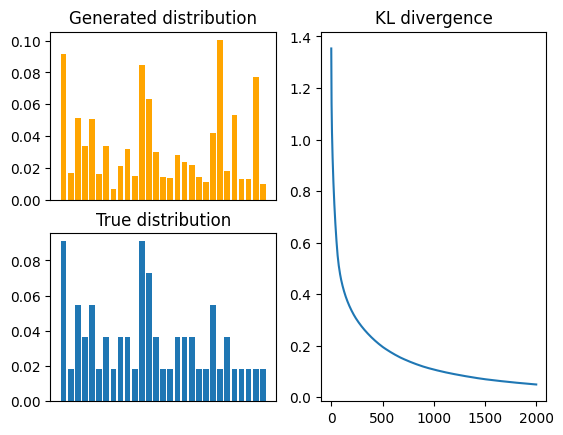

In [440]:
import matplotlib.pyplot as plt
fig, axs = plt.subplot_mosaic(
    [["generated", "kl"], ["true", "kl"]], width_ratios=[2, 2]
)

generated_sum = {k: 0 for k in generated[0].keys()}

for p_generated in [
    generated[i]
    for i in range(
        len(generated.keys()) - int(len(generated.keys()) / 1), len(generated.keys())
    )
]:
    for k, v in p_generated.items():
        generated_sum[k] += v / 1

axs["true"].bar(P.keys(), [v / sum(P.values()) for v in P.values()])
axs["generated"].bar(
    generated_sum.keys(),
    [v / sum(generated_sum.values()) for v in generated_sum.values()],
    color="orange",
)
axs["kl"].plot(kls)
axs["true"].set_title("True distribution")
axs["generated"].set_title(f"Generated distribution")
axs["kl"].set_title("KL divergence")
axs["true"].set_xticks([])
axs["generated"].set_xticks([])
plt.show()

In [441]:
from disassembly.estimate_weights import estimate_weights


G, kls, generated, weights = estimate_weights(
    P=P,
    #meta_enzyme=enzymes.meta_enzyme,
    exo_mult_factor=10,
    lr=2,
    n_iterations=500,
    N_T=200,
    alpha=0.05,
)


 99 / 500 | 4.96, mean: 4.51 | Increasing | nz: 180
Learning rate decreased to 1.0
 182 / 500 | 2.57, mean: 2.29 | Increasing | nz: 236
Learning rate decreased to 0.5
 258 / 500 | 0.42, mean: 0.55 | Increasing | nz: 289
Learning rate decreased to 0.25
 374 / 500 | 0.15, mean: 0.30 | Increasing | nz: 295
Learning rate decreased to 0.125
 499 / 500 | 0.33, mean: 0.21 | Plateau | nz: 295295

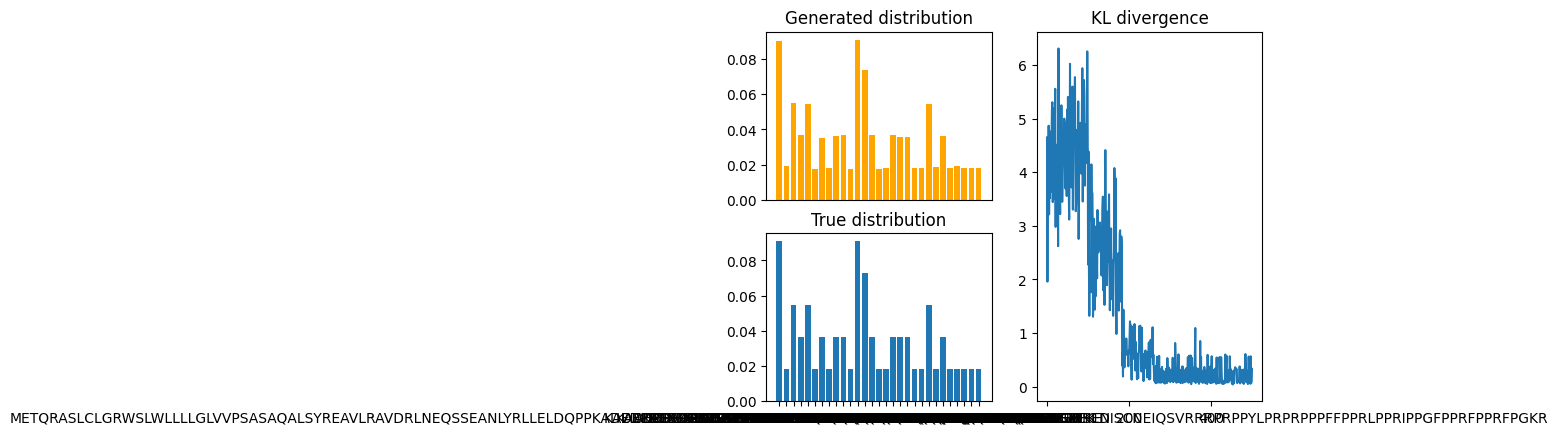

In [442]:
import matplotlib.pyplot as plt
fig, axs = plt.subplot_mosaic(
    [["generated", "kl"], ["true", "kl"]], width_ratios=[2, 2]
)

generated_sum = {k: 0 for k in generated[0].keys()}

for p_generated in [
    generated[i]
    for i in range(
        len(generated.keys()) - int(len(generated.keys()) / 10), len(generated.keys())
    )
]:
    for k, v in p_generated.items():
        generated_sum[k] += v / 10

axs["true"].bar(P.keys(), [v / sum(P.values()) for v in P.values()])
axs["generated"].bar(
    generated_sum.keys(),
    [v / sum(generated_sum.values()) for v in generated_sum.values()],
    color="orange",
)
axs["kl"].plot(kls)
axs["true"].set_title("True distribution")
axs["generated"].set_title(f"Generated distribution")
axs["kl"].set_title("KL divergence")
#axs["true"].set_xticks([])
axs["generated"].set_xticks([])
plt.show()